# Author: Dominik Stipić

# ML

In [0]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
tweets_train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data/bert/train_clean_bert.csv', encoding='utf-8', header=0, names=['tweet', 'class'])
tweets_test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data/bert/test_clean_bert.csv', encoding='utf-8', header=0, names=['tweet', 'class'])

gender_train = tweets_train[tweets_train['class'] != 'bot']
gender_test = tweets_test[tweets_test['class'] != 'bot']

train_n = len(gender_train)

gender_dataset = pd.concat([gender_train, gender_test], ignore_index=True)

print(pd.Series(gender_dataset['tweet']).str.split(' ').str.len().sort_values(ascending=False)[:100])

print(gender_dataset.head())

76275     7503
76172     4047
149430    3488
166846    3181
67696     2650
          ... 
281547      57
230149      57
21415       57
284883      57
92033       57
Name: tweet, Length: 100, dtype: int64
                                               tweet   class
0  is that the right thing to serve the wongs hav...  female
1  the states is great an all but by the looks of...    male
2  did you know that jacques tati came to the set...    male
3     fuck excuses learn to admit when you fucked up  female
4  hello ella what's the best email to get you at...  female


In [0]:
file_path = "/content/gdrive/My Drive/Colab Notebooks/data/bert_features/"
X = np.load(file_path+"features.npy", allow_pickle=True)
y = list(gender_dataset["class"])

In [0]:
le = LabelEncoder()
labels = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33, random_state=42)

In [0]:
def model_selection(X, y, model, param_grid, cv):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, verbose=0)
    grid_search = grid_search.fit(X,y)
    report = grid_search.cv_results_
    df = pd.DataFrame(report)
    print(df)
    return grid_search.best_estimator_

# LOG_REG

In [0]:
clf = LogisticRegression(C=1e5, solver="saga", multi_class="multinomial", max_iter=1000)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      female       0.61      0.64      0.63     48000
        male       0.63      0.60      0.61     48246

    accuracy                           0.62     96246
   macro avg       0.62      0.62      0.62     96246
weighted avg       0.62      0.62      0.62     96246



#SVM

In [0]:
from sklearn.svm import SVC
clf = SVC(C=1, gamma="auto", kernel="rbf", max_iter=3000)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

      female       0.47      0.02      0.04     48000
        male       0.50      0.98      0.66     48246

    accuracy                           0.50     96246
   macro avg       0.48      0.50      0.35     96246
weighted avg       0.48      0.50      0.35     96246



#NN

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pdb

def evaluate(loader, model, loss, config):
  model.eval()
  with torch.no_grad():
    valid_loss = 0
    cnt_correct   = 0 
    for input_batch, target_batch in loader:
        logits = model(input_batch)
        loss_val = loss(logits, target_batch)
        yp = logits.argmax(axis=1)
        cnt_correct += (yp == target_batch).sum().item()
        valid_loss +=  loss_val.item()
    valid_loss /= len(loader)
    valid_acc  = cnt_correct / (len(loader)*config["batch_size"])
    return valid_loss, valid_acc

def train(model, X, y, loss, optimizer, lr_scheduler, config):
    optimizer = optimizer(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]) 
    scheduler = lr_scheduler(optimizer, gamma=config["gamma"])
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=config["valid_ratio"])
    loader_train = DataLoader(dataset =list(zip(X_train, y_train)), batch_size=config["batch_size"])
    loader_valid = DataLoader(dataset =list(zip(X_valid, y_valid)), batch_size=config["batch_size"])
    epochs = config["max_epochs"]
    error_dict = {"valid" : [], "train" : []}
    #pdb.set_trace()
    for epoch in range(1,epochs+1):
        model.train()
        training_loss = 0
        cnt_correct   = 0 
        for i, (input_batch, target_batch) in enumerate(loader_train):
            #input_batch, target_batch = input_batch.cuda(), target_batch.cuda() 
            logits = model(input_batch)
            batch_loss = loss(logits, target_batch)
            yp = logits.argmax(axis=1)
            cnt_correct += (yp == target_batch).sum().item()
            training_loss +=  batch_loss.item()
            batch_loss.backward()
            optimizer.step()
            model.zero_grad()
            if i % config["print_time"] == 0:
                progress = round(((i+1)*config["batch_size"])/(config["batch_size"]*len(loader_train)),2)
                print(f"    epoch {epoch}, progress {round(progress*100,2)}, batch loss = {batch_loss}")
        training_loss /= len(loader_train)
        training_acc   = cnt_correct / (len(loader_train)*config["batch_size"])
        validation_loss, validation_acc = evaluate(loader_valid, model, loss, config)
        print(f"*** epoch {epoch}, step={round(scheduler.get_last_lr()[0],2)}, train_loss={training_loss}, train_acc={training_acc}, valid_loss={validation_loss}, valid_acc={validation_acc}\n")    
        scheduler.step()
        error_dict["valid"].append((validation_loss, validation_acc))
        error_dict["train"].append((training_loss, training_acc))
        if config["optimal_weights"]:
          file_path = config["file"] 
          torch.save(model.state_dict(), file_path + f"/w{epoch}.txt")
    if config["optimal_weights"]:
      generalization = [x for x,y in error_dict["valid"]]
      best = np.argmin(generalization)
      print(f"picking model {best}")
      file_path = config["file"]
      model.load_state_dict(torch.load(file_path + f"/w{best+1}.txt"))
    return model, error_dict

In [0]:
def evaluation_routine(loader_test, model, loss, config):
  loader_test = DataLoader(dataset =list(zip(X_test, y_test)), batch_size=config["batch_size"])

  test_error, test_acc = evaluate(loader_test, model, loss, config)
  print(f"test_error = {test_error}, acc = {test_acc}")

  valid_error = [t[0]for t in error_dict["valid"]]
  valid_acc = [t[1] for t in error_dict["valid"]]
  train_error = [t[0]for t in error_dict["train"]]
  train_acc = [t[1]for t in error_dict["train"]]

  plt.plot(valid_error, label = "valid_error")
  plt.plot(train_error, label = "train_error")
  plt.legend()
  plt.show()

  plt.plot(valid_acc, label = "valid_acc")
  plt.plot(train_acc, label = "train_acc")
  plt.legend()
  plt.show()
  return test_error, test_acc

In [0]:
tweets_train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data/bert/train_clean_bert.csv', encoding='utf-8', header=0, names=['tweet', 'class'])
tweets_test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data/bert/test_clean_bert.csv', encoding='utf-8', header=0, names=['tweet', 'class'])

gender_train = tweets_train[tweets_train['class'] != 'bot']
gender_test = tweets_test[tweets_test['class'] != 'bot']

train_n = len(gender_train)

gender_dataset = pd.concat([gender_train, gender_test], ignore_index=True)
labels = LabelEncoder().fit_transform(gender_dataset['class'])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33)
print(X_train.shape, X_test.shape)

# dimensions = X_train.shape[1]
# X_train = PCA(n_components=dimensions//4).fit_transform(X_train)
# X_test = PCA(n_components=dimensions//4).fit_transform(X_test)
# print(X_train.shape, X_test.shape)
# print(y_train.shape, y_test.shape)

(195406, 768) (96246, 768)


In [0]:
dimensions = X_test.shape[1]
model = nn.Sequential(
            nn.Linear(dimensions, dimensions+10),
            nn.BatchNorm1d(dimensions+10),
            nn.ReLU(),
            nn.Linear(dimensions+10,dimensions),
            nn.BatchNorm1d(dimensions),
            nn.Linear(dimensions,dimensions//4),
            nn.BatchNorm1d(dimensions//4),
            nn.Linear(dimensions//4,dimensions//8),
            nn.BatchNorm1d(dimensions//8), 
            nn.Linear(dimensions//8,2))

config = {"lr" : 0.1,
          "weight_decay" : 0.1,
          "max_epochs" : 50,
          "batch_size" : 32, 
          "gamma" : 0.7,
          "valid_ratio" : 0.1,
          "print_time" : 10,
          "optimal_weights" : True,
          "file" : "/content/gdrive/My Drive/Colab Notebooks/data/weights"}

optimizer = optim.Adam
lr_scheduler = optim.lr_scheduler.ExponentialLR
loss = nn.CrossEntropyLoss()
print(dimensions)
trained_model, error_dict = train(model, X_test, y_test, loss, optimizer, lr_scheduler, config)

test_error = 0.6934306572013079, acc = 0.5042283078457447


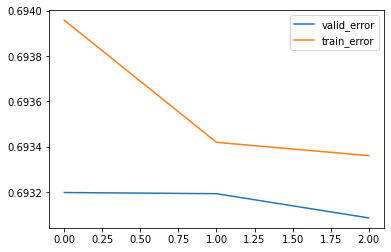

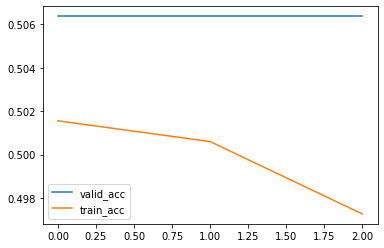

(0.6934306572013079, 0.5042283078457447)

In [0]:
evaluation_routine(loader_test, model, loss, config)

#Different architectures

In [0]:
c1 = [1,1/2, 1/2]
c2 = [1,3/4, 1/4]
c3 = [1,2/3, 1/3]

c4 = [1/2,1/2]
c5 = [2/3,1/3]
c6 = [3/4,1/4]

c7 = [1/2]
c8 = [1/3]
c9 = [1/4]
c10 = [2/3]
c11 = [3/4]

configurations = [c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11]
dimensions = X_test.shape[1]

def get_configuration(conf, dimensions):
  for c in conf:
    xs = [nn.Linear(dimensions, int(dimensions*2)),nn.BatchNorm1d(int(dimensions*2)), nn.ReLU()]
    for factor in c:
      a = nn.Linear(xs[-2].num_features,int(dimensions*factor))
      b = nn.BatchNorm1d(int(dimensions*factor))
      xs.append(a)
      xs.append(b)
      xs.append(nn.ReLU())
    xs.append(nn.Linear(int(dimensions*c[-1]),2))
    xs.append(nn.BatchNorm1d(2))
    yield nn.Sequential(*xs)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33)

dimensions = X_train.shape[1]
X_train = PCA(n_components=dimensions//4).fit_transform(X_train)
X_test = PCA(n_components=dimensions//4).fit_transform(X_test)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

print(X_train.shape, X_test.shape)
X_train = X_train[:50000]
y_train = y_train[:50000]

(195406, 192) (96246, 192)
(195406,) (96246,)
(195406, 192) (96246, 192)


In [0]:
dims = X_test.shape[1]

config = {"lr" : 0.01,
          "weight_decay" : 0.1,
          "max_epochs" : 3,
          "batch_size" : 32, 
          "gamma" : 0.7,
          "valid_ratio" : 0.1,
          "print_time" : 40,
          "optimal_weights" : True,
          "file" : "/content/gdrive/My Drive/Colab Notebooks/data/weights"}

optimizer = optim.Adam
lr_scheduler = optim.lr_scheduler.ExponentialLR
loss = nn.CrossEntropyLoss()

A = []
for m in get_configuration(configurations, dims):
  print(m)
  model, error_dict = train(m, X_train, y_train, loss, optimizer, lr_scheduler, config)
  loader_test = DataLoader(dataset =list(zip(X_test, y_test)), batch_size=config["batch_size"])
  error,acc = evaluation_routine(loader_test, model, loss, config)
  A.append(acc)

#KNN


In [0]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)

In [0]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.53      0.53     47697
           1       0.53      0.53      0.53     48549

    accuracy                           0.53     96246
   macro avg       0.53      0.53      0.53     96246
weighted avg       0.53      0.53      0.53     96246



# LDA


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, IncrementalPCA
import pdb
import matplotlib.pyplot as plt
from google.colab import drive
import gensim
import seaborn as sns
from google.colab import output
from collections import Counter

from gensim.models import CoherenceModel
import gensim.corpora as corpora


drive.mount("/content/gdrive")
!pip install ipython-autotime
%load_ext autotime
!pip install PyLDAvis


def read_corpus(name):
    X = []
    Y = []
    with open(name,"r") as f:
        for line in f:
            m,y = line.split(",")
            X.append(m.strip())
            Y.append(y.strip())
    return X,Y  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=fe64c0086085ff60e58832fc8f76d1821d356d14ba618a77c893b9a175f97a93
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime
     |████████████████████████████████| 1.6MB 8.8MB/s 
     |████████████████████████████████| 552kB 48.3MB/s 
  Created wheel for PyLDAvis: filename=py

In [0]:
X,y = read_corpus("/content/gdrive/My Drive/Colab Notebooks/data/corpus/train_clean2")
tweets_train = pd.DataFrame(zip(X,y), columns = ["tweet","class"])

X,y = read_corpus("/content/gdrive/My Drive/Colab Notebooks/data/corpus/test_clean2")
tweets_test = pd.DataFrame(zip(X,y), columns = ["tweet","class"])
df = pd.concat([tweets_train, tweets_test], ignore_index=True)
df.head()

In [0]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


time: 1min 6s


GENSIM

In [0]:
sample = df.sample(n=20000)
print(Counter(sample["class"]))
tweets = sample["tweet"]
words = [t.split() for t in tweets]

words = [[w for w in xs if w not in ["amp", "http"]]for xs in words ]
flat_list = [item for sublist in words for item in sublist]
c = Counter(flat_list)
c.most_common(100)



In [0]:
d = corpora.Dictionary(words)
corpus = [d.doc2bow(w) for w in words]
m1 = gensim.models.LdaMulticore(corpus=corpus,
                                id2word=d,
                                num_topics=3,
                                chunksize=100,
                                passes=20,
                                per_word_topics=True)

m2 = gensim.models.LdaMulticore(corpus=corpus,
                                id2word=d,
                                num_topics=4, 
                                chunksize=100,
                                passes=20,
                                per_word_topics=True)

m3 = gensim.models.LdaMulticore(corpus=corpus,
                                id2word=d,
                                num_topics=5, 
                                chunksize=100,
                                passes=20,
                                per_word_topics=True)

In [0]:
c1 = CoherenceModel(model=m1, texts=words, dictionary=d, coherence='c_v')
c2 = CoherenceModel(model=m2, texts=words, dictionary=d, coherence='c_v')
c3 = CoherenceModel(model=m3, texts=words, dictionary=d, coherence='c_v')

print('Coherence Score 1: ', c1.get_coherence())
print('Coherence Score 2: ', c2.get_coherence())
print('Coherence Score 3: ', c3.get_coherence())


Coherence Score 1:  0.40761592534621255
Coherence Score 2:  0.3591357212363276
Coherence Score 3:  0.40712218506368314
time: 2.13 s


In [0]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(m1, corpus, d)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.210758  0.132777       1        1  40.879032
1      0.029064 -0.222498       2        1  32.167110
2     -0.239823  0.089721       3        1  26.953852, topic_info=        Term        Freq       Total Category  logprob  loglift
8        job  618.000000  618.000000  Default  30.0000  30.0000
160     like  572.000000  572.000000  Default  29.0000  29.0000
419      get  581.000000  581.000000  Default  28.0000  28.0000
104      new  721.000000  721.000000  Default  27.0000  27.0000
971    trump  423.000000  423.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
89     group  121.262459  121.955864   Topic3  -5.9305   1.3053
949     work  195.319382  386.673889   Topic3  -5.4538   0.6281
16   support  149.736633  202.620102   Topic3  -5.7196   1.0086
721  looking  138.631348  262.282684   Topic3  -5.7966   0.6734
104      new  124.632294  721.078491   Topic3  -5.9031  -0.4443

[166 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1698      1  0.998022    always
99        2  0.901037  american
99        3  0.091014  american
1025      3  0.997289   analyst
796       2  0.996821   another
...     ...       ...       ...
896       2  0.209162     would
61        1  0.344354      year
61        2  0.476798      year
61        3  0.177271      year
2993      1  0.995258     youre

[187 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

time: 24.5 s


In [0]:

pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(m2, corpus, d)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.113257 -0.101070       1        1  28.866800
0     -0.303356  0.018929       2        1  27.321247
2      0.070715 -0.151690       3        1  23.770393
3      0.119384  0.233831       4        1  20.041565, topic_info=       Term        Freq       Total Category  logprob  loglift
8       job  619.000000  619.000000  Default  30.0000  30.0000
971   trump  409.000000  409.000000  Default  29.0000  29.0000
397    make  402.000000  402.000000  Default  28.0000  28.0000
315    good  424.000000  424.000000  Default  27.0000  27.0000
167    know  362.000000  362.000000  Default  26.0000  26.0000
...     ...         ...         ...      ...      ...      ...
246     one   97.458092  698.758850   Topic4  -5.8527  -0.3625
59      see   86.801346  362.201233   Topic4  -5.9685   0.1788
1995   last   81.826675  282.074768   Topic4  -6.0275   0.3698
135   today   83.615105  402.464813   Topic4  -6.0059   0.0360
481   first   79.215416  324.829590   Topic4  -6.0600   0.1962

[222 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2681      3  0.992907    almost
2067      3  0.991894   already
1698      1  0.993039    always
1025      2  0.994908   analyst
2040      1  0.993558  anything
...     ...       ...       ...
61        3  0.324823      year
61        4  0.066995      year
33        2  0.238135       yes
33        4  0.754094       yes
2993      1  0.991995     youre

[267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

time: 23.3 s


In [0]:

pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(m3, corpus, d)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.134035  0.175527       1        1  23.424126
3     -0.329975  0.068201       2        1  22.661140
4      0.118469  0.104881       3        1  21.058355
1      0.048644 -0.171463       4        1  17.208874
0      0.028827 -0.177147       5        1  15.647511, topic_info=          Term        Freq       Total Category  logprob  loglift
8          job  629.000000  629.000000  Default  30.0000  30.0000
315       good  417.000000  417.000000  Default  29.0000  29.0000
135      today  391.000000  391.000000  Default  28.0000  28.0000
191   engineer  299.000000  299.000000  Default  27.0000  27.0000
4    developer  291.000000  291.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
971      trump   73.756638  413.347778   Topic5  -5.8839   0.1313
667       open   58.099842  113.544708   Topic5  -6.1225   1.1848
158        got   58.192822  209.123291   Topic5  -6.1209   0.5757
185     people   59.475407  594.945740   Topic5  -6.0991  -0.4480
303       time   59.091789  593.548157   Topic5  -6.1056  -0.4522

[281 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
236       3  0.987645        added
1025      2  0.998095      analyst
2040      4  0.992225     anything
0         2  0.995946  application
3375      5  0.991546       attack
...     ...       ...          ...
209       3  0.989696          yet
834       4  0.991267         york
786       3  0.995862        young
2993      1  0.851500        youre
2993      4  0.145378        youre

[361 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 2, 1])

time: 23.1 s


# SKLEARN - LDA


In [0]:
from sklearn.decomposition import LatentDirichletAllocation

time: 840 µs


In [0]:
X,y = read_corpus("/content/gdrive/My Drive/Colab Notebooks/data/corpus/train_clean2")
tweets_train = pd.DataFrame(zip(X,y), columns = ["tweet","class"])

X,y = read_corpus("/content/gdrive/My Drive/Colab Notebooks/data/corpus/test_clean2")
tweets_test = pd.DataFrame(zip(X,y), columns = ["tweet","class"])
df = pd.concat([tweets_train, tweets_test], ignore_index=True)
df.head()

tweet   class
0                            tbh need thats everyone    male
1  needed barcelona lionel messi league goal mile...    male
2                                 screen home moment    male
3  senior software engineer req work position sup...     bot
4  employee check gov immorality real pay vacatio...  female

time: 4.2 s


In [0]:
sample = df.sample(n=10000)
print(Counter(sample["class"]))
tweets = sample["tweet"]
words = [t.split() for t in tweets]
words = [[w.strip() for w in xs if w not in ["amp", "http","now"]]for xs in words ]
tweets = [" ".join(xs) for xs in words]
print(tweets[0])

Counter({'bot': 3869, 'male': 3090, 'female': 3041})
frontline service operation location andor subscribing compliance indianapolis analyst associate river including customer hosting application suite crnfix charles provide saas summary support management client
time: 71.3 ms


In [0]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(list(tweets))
print(dtm_tf.shape)

(10000, 1535)
time: 164 ms


In [0]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(tweets)
print(dtm_tfidf.shape)

(10000, 1535)
time: 163 ms


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1817: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


In [0]:
#lda0 = LatentDirichletAllocation(n_components=2).fit(dtm_tfidf)
#lda1 = LatentDirichletAllocation(n_components=3).fit(dtm_tfidf)
lda = LatentDirichletAllocation(n_components=4).fit(dtm_tfidf)
#lda3 = LatentDirichletAllocation(n_components=5).fit(dtm_tfidf)


output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')


time: 13.7 s


In [0]:
import pyLDAvis
import pyLDAvis.sklearn
zero = pyLDAvis.sklearn.prepare(lda0, dtm_tf, tf_vectorizer, mds="tsne")

time: 6.01 s


In [0]:
first = pyLDAvis.sklearn.prepare(lda1, dtm_tf, tf_vectorizer, mds="tsne")

time: 4.94 s


In [0]:
sec = pyLDAvis.sklearn.prepare(lda2, dtm_tf, tf_vectorizer,mds="tsne")

time: 4.99 s


In [0]:
third = pyLDAvis.sklearn.prepare(lda3, dtm_tf, tf_vectorizer, mds="tsne")

NameError: ignored

time: 139 ms


In [0]:
pyLDAvis.save_html(zero, 'lda0.html')
pyLDAvis.save_html(first, 'lda1.html')
pyLDAvis.save_html(sec, 'lda2.html')
pyLDAvis.save_html(third, 'lda3.html')


time: 13.4 ms


# Calculating label and topic distribution similarity


In [0]:
print(lda.components_.shape)
print(len(tf_vectorizer.get_feature_names()))

(4, 1535)
1535
time: 2.3 ms


In [0]:
zs = lda.components_.sum(axis=1)
topic_distibutions = []
for i,z in enumerate(zs):
  p = lda.components_[i] / z
  topic_distibutions.append(p)
topic_distibutions = np.array(topic_distibutions)

features = np.array(tf_vectorizer.get_feature_names())
print(features[1:10])
print(features.shape)

['able' 'abortion' 'absolute' 'absolutely' 'accept' 'access' 'according'
 'account' 'achieve']
(1535,)
time: 6.96 ms


In [0]:
y = sample["class"]
y[y == "male"] = "human"
y[y == "female"] = "human"
print(len(y), len(words))

d = {"bot" : [], "human" : []}
for tweet, y in zip(words, y):
  for word in tweet:
    d[y].append(word) 

bot_words = d["bot"]
human_words = d["human"]
word_categories = len(set(bot_words+human_words))
bot_dict = dict(Counter(bot_words))
human_dict = dict(Counter(human_words))
target_freq = {"human" : len(human_dict), "bot" : len(bot_dict)}
target_freq

10000 10000


{'bot': 10660, 'human': 11732}

time: 52 ms


In [0]:
Z = sum(list(bot_dict.values()))
for key in bot_dict.keys():
  n = bot_dict.get(key)
  p = (1+n)/(Z+word_categories)
  #p = n/Z
  bot_dict[key] = p

time: 10.5 ms


In [0]:
Z = sum(list(bot_dict.values()))
for key in human_dict.keys():
  n = human_dict.get(key)
  p = (1+n)/(Z+word_categories)
  #p = n/Z
  human_dict[key] = p

time: 8.22 ms


In [0]:
bot_smoothing_factor = 1/(target_freq["bot"] + word_categories)
bot_distibution = np.repeat(bot_smoothing_factor, len(features))
for key in bot_dict.keys():
  if key in features:
    index = np.where(features == key)[0].item()
    bot_distibution[index] = bot_dict[key]

time: 237 ms


In [0]:
human_smoothing_factor = 1/(target_freq["human"] + word_categories)
human_distibution = np.repeat(human_smoothing_factor, len(features))
for key in human_dict.keys():
  if key in features:
    index = np.where(features == key)[0].item()
    human_distibution[index] = human_dict[key]

time: 369 ms


In [0]:
human_distibution = human_distibution / human_distibution.sum() 
bot_distibution = bot_distibution / bot_distibution.sum() 

time: 1.65 ms


In [0]:
xs = topic_distibutions[2].argsort()[::-1][:5]
features[xs]

array(['new', 'day', 'thanks', 'look', 'need'], dtype='<U19')

time: 4.54 ms


In [0]:
from scipy.special import rel_entr
from scipy.spatial.distance import jensenshannon
hs = []
bs = []

for dist in topic_distibutions:
  similarity_h = jensenshannon(human_distibution, dist, base=2)
  similarity_b = jensenshannon(bot_distibution, dist, base=2)
  hs.append(similarity_h)
  bs.append(similarity_b)

print(hs)
print(bs)
  

[0.6140819110893333, 0.500013507253619, 0.4628584187506194, 0.5036903261867528]
[0.4482536728686455, 0.5746528525042341, 0.602080309728354, 0.6060691753626493]
time: 6.81 ms


In [0]:
features[0:3]

array(['abc', 'ability', 'able'], dtype='<U19')

time: 2.61 ms


In [0]:
# Trial 2

y = sample["class"]
y[y == "male"] = "human"
y[y == "female"] = "human"
print(len(y), len(words))

d = {"bot" : [], "human" : []}
for tweet, y in zip(words, y):
  for word in tweet:
    d[y].append(word) 

bot_words = d["bot"]
human_words = d["human"]
word_categories = len(set(bot_words+human_words))
bot_dict = dict(Counter(bot_words))
human_dict = dict(Counter(human_words))

xs = []
for f in features:
  if f not in bot_dict.keys():
    xs.append((f, 0))
  else:
    xs.append((f, bot_dict[f]))

ys = []
for f in features:
  if f not in human_dict.keys():
    ys.append((f, 0))
  else:
    ys.append((f, human_dict[f]))

10000 10000
time: 58.2 ms


time: 1.26 ms


In [0]:
# MLE
db = dict(xs)
dh = dict(ys)
# {word : freq}

for key in db.keys():
  value_bot   = db[key]
  value_human = dh[key]
  N = (value_bot + value_human)
  db[key] = (value_bot)/N
  dh[key] = (value_human)/N

time: 6.39 ms


In [0]:
# MAP
db = dict(xs)
dh = dict(ys)
# {word : freq}

for key in db.keys():
  value_bot   = db[key]
  value_human = dh[key]
  N = (value_bot + value_human)
  db[key] = (value_bot+1)/(N+word_categories)
  dh[key] = (value_human+1)/(N+word_categories)

time: 5.37 ms


In [0]:
human_distibution = []
bot_distibution   = []

for f in features:
  human_distibution.append(dh[f])
  bot_distibution.append(db[f])

time: 2.85 ms


In [0]:
def most_common(xs, k):
  most_common = xs.argsort()[::-1][:k]
  return most_common

topic1 = features[most_common(topic_distibutions[0],20)]
topic1

array(['new', 'day', 'love', 'time', 'morning', 'free', 'big', 'home',
       'house', 'today', 'amazing', 'going', 'game', 'win', 'work',
       'world', 'week', 'look', 'good', 'twitter'], dtype='<U19')

time: 4.88 ms


['right' 'like' 'trump' 'life' 'tell' 'yes' 'want' 'news' 'read' 'live'
 'woman' 'story' 'getting' 'american' 'play' 'thanks' 'god' 'president'
 'tweet' 'really' 'history' 'true' 'people' 'make' 'hate' 'fucking' 'look'
 'girl' 'power' 'hard']


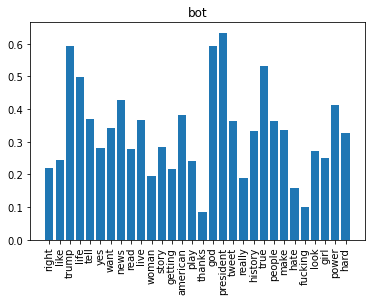

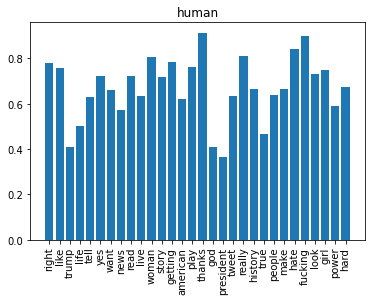

time: 608 ms


In [0]:
def fun(n, k):
  xs,ys = [],[]
  arr = features[most_common(topic_distibutions[n],k)]
  print(arr)
  for f in arr:
    xs.append(dh[f])
    ys.append(db[f])
  b = ys
  h = xs
  xs = np.arange(len(b))
  plt.title("bot")
  plt.bar(xs, b)
  plt.xticks(xs, arr)
  plt.xticks(rotation=90)
  plt.show()
  plt.title("human")
  plt.bar(xs,h)
  plt.xticks(xs, arr)
  plt.xticks(rotation=90)
  plt.show()

fun(1,30)

In [0]:
def create_df(dictionary):
  keys,values = [],[]
  for key in dictionary:
    value = dictionary[key]
    keys.append(key)
    values.append(value)
  d = {"word":keys, "prob":values}
  df = pd.DataFrame.from_dict(d)
  return df

def create_topic_df(topics, ftrs):
  xs = []
  for i, t in enumerate(topics):
    dictionary = {}
    for word, prob in zip(ftrs, t):
      dictionary[word] = prob
    df = create_df(dictionary)
    df["topic"] = i+1
    xs.append(df)
  df = pd.concat(xs)
  return df
  

human_df = create_df(dh)
bot_df = create_df(db)
topic_df = create_topic_df(topic_distibutions, features)

time: 28.3 ms


In [0]:
human_df.to_csv("human_lda.csv")
bot_df.to_csv("bot_lda.csv")
topic_df.to_csv("topic_lda.csv")

time: 66.6 ms


In [0]:
db = dict(xs)
dh = dict(ys)

time: 1.33 ms


In [0]:
xs = create_df(db)
ys = create_df(dh)
xs.to_csv("bot_freq.csv")
ys.to_csv("human_freq.csv")

time: 14.3 ms
